In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("commodity-futures-trading-anomaly-detection.csv")

In [3]:
# Drop non-numeric columns
df.drop(columns=['Id', 'Date', 'Target_Class', 'Anomaly'], inplace=True, errors='ignore')

In [4]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [5]:
# Split train-test (Assume first 80% is normal data)
train_size = int(len(data_scaled) * 0.8)
X_train, X_test = data_scaled[:train_size], data_scaled[train_size:]

In [6]:
# Define Autoencoder
input_dim = X_train.shape[1]

In [7]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
latent_space = Dense(8, activation='relu', name="latent_space")(encoded)

In [8]:
decoded = Dense(16, activation='relu')(latent_space)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

In [9]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
# Train Autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0813 - val_loss: 0.0731
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0751 - val_loss: 0.0696
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0691 - val_loss: 0.0667
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0590 - val_loss: 0.0648
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0520 - val_loss: 0.0629
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0453 - val_loss: 0.0626
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0407 - val_loss: 0.0613
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0348 - val_loss: 0.0597
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0320 - val_loss: 0.0586
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0300 - val_loss: 0.0574
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0273 - val_loss: 0.0556
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [11]:
# Extract latent features
encoder = Model(inputs=input_layer, outputs=latent_space)
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [12]:
shapes = []

shapes.append({"Label":"X Train Latent", "Shape": X_train_latent.shape})
shapes.append({"Label":"X Test Latent", "Shape": X_test_latent.shape})
shapes.append({"Label":"X Train", "Shape": X_train.shape})
shapes.append({"Label":"X Test", "Shape": X_test.shape})

shapes_df = pd.DataFrame(shapes)

In [13]:
shapes_df.to_csv("Data/commodity-futures-trading-anomaly-detection-autoencoder.csv")

In [14]:
# Train One-Class SVM on normal latent features
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # Adjust `nu` for sensitivity
svm.fit(X_train_latent)

OneClassSVM(gamma='auto', nu=0.01)

In [15]:
y_pred_svm = svm.predict(X_test_latent)
y_pred_autoencoder = np.mean(np.abs(autoencoder.predict(X_test) - X_test), axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [16]:
# Convert predictions: -1 = Anomaly, 1 = Normal
svm_anomalies = (y_pred_svm == -1).astype(int)
threshold = np.percentile(y_pred_autoencoder, 95)  # 95th percentile for anomaly cutoff
autoencoder_anomalies = (y_pred_autoencoder > threshold).astype(int)

In [17]:
# Combine anomaly predictions (Both methods must agree)
final_anomalies = (svm_anomalies & autoencoder_anomalies)

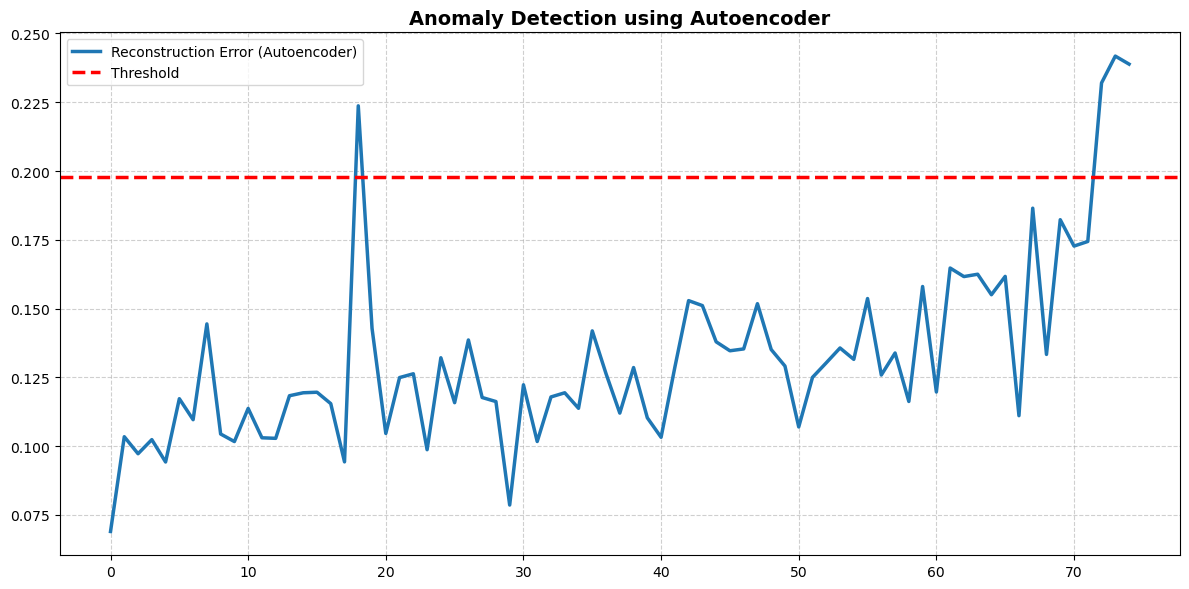

In [18]:
# Visualize anomaly scores
plt.figure(figsize=(12, 6))
plt.plot(y_pred_autoencoder, label="Reconstruction Error (Autoencoder)", linewidth=2.5)
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold", linewidth=2.5)
plt.title("Anomaly Detection using Autoencoder", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid
plt.tight_layout() #avoid labels being cutoff
plt.savefig("Plots/Anomaly Detection using Autoencoder.png", dpi=200)
plt.show()

In [32]:
# Load dataset
df = pd.read_csv("commodity-futures-trading-anomaly-detection.csv")

In [33]:
# Drop non-numeric columns
df.drop(columns=['Id', 'Date', 'Target_Class', 'Anomaly'], inplace=True, errors='ignore')

In [34]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [35]:
# Convert data into sequences (time-series format)
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

In [36]:
seq_length = 30  # Use past 30 days to predict the next
X_sequences = create_sequences(data_scaled, seq_length)

In [37]:
# Split into train-test (Assume first 80% is normal data)
train_size = int(len(X_sequences) * 0.8)
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]

In [38]:
# Define LSTM Autoencoder
input_dim = X_train.shape[2]

In [39]:
input_layer = Input(shape=(seq_length, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)

In [40]:
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(input_dim))(decoded)

In [42]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [43]:
# Train Autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - loss: 0.2077 - val_loss: 0.1260
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1287 - val_loss: 0.0931
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0923 - val_loss: 0.0701
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0685 - val_loss: 0.0622
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0520 - val_loss: 0.0600
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0412 - val_loss: 0.0531
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0351 - val_loss: 0.0525
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0312 - val_loss: 0.0502
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0281 - val_loss: 0.0469
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0266 - val_loss: 0.0464
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0239 - val_loss: 0.0426
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0226 - val_loss: 0.0420

In [44]:
# Predict and Compute Reconstruction Error
X_test_pred = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))

1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/stepWARNING:tensorflow:6 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A5CF927B00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step


In [45]:
# Set Anomaly Threshold (95th percentile)
threshold = np.percentile(reconstruction_errors, 95)
anomalies = (reconstruction_errors > threshold).astype(int)

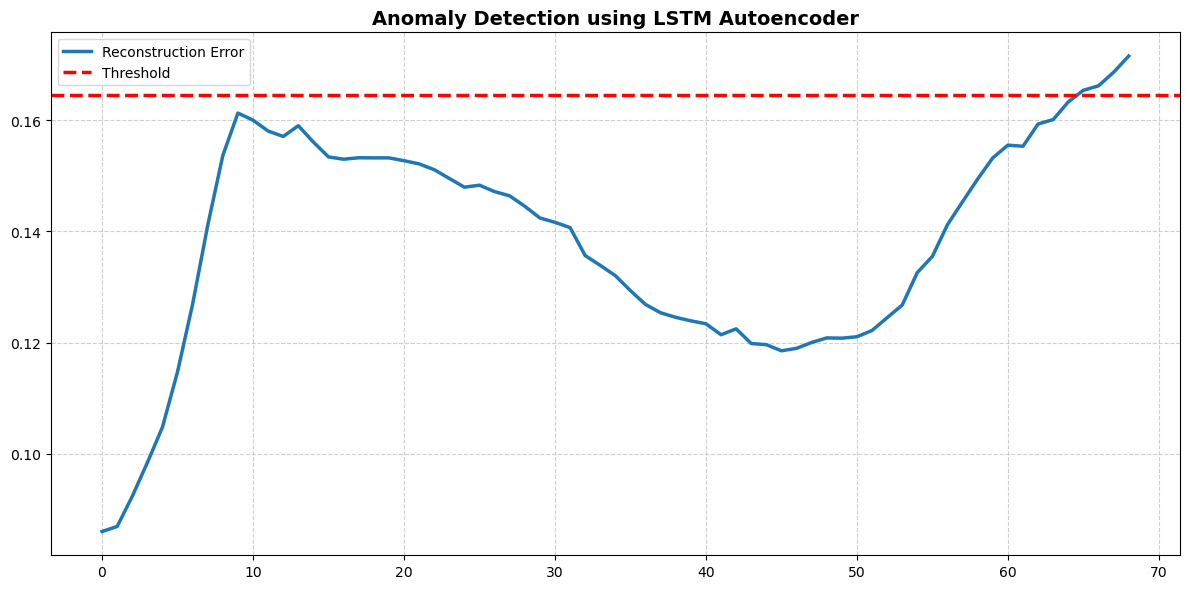

In [47]:
# Visualize reconstruction errors
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label="Reconstruction Error", linewidth=2.5)
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold", linewidth=2.5)
plt.title("Anomaly Detection using LSTM Autoencoder", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid
plt.tight_layout() #avoid labels being cutoff
plt.show()